In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [2]:
class TwoBodyOrbit():
    """
    TwoBodyOrbit class implements the parameters and Lagrange's 
    equations for the two-body problem for gravitational attraction
    between two bodies in Cartesian coordinates.
     
    Parameters
    ----------
    m1 : float
        mass of first pendulum bob
    m2 : float
        mass of second pendulum bob
    G : float
        Universal gravitational constant

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    solve_ode(t_pts, x1_0, x1_dot_0, y1_0, y1_dot_0,
              x2_0, x2_dot_0, y2_0, y2_dot_0, abserr, relerr)
        Solve the ODE using solve_ivp given initial conditions x1_0, x1_dot_0, 
        y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, and y2_dot_0, and a range of 
        t values, t_pts. It solves at a given absolute error, abserr, 
        and relative error, relerr.
    
    """
    def __init__(self, mass1=1., mass2=1., G=1.
                ):
        self.m1 = mass1
        self.m2 = mass2
        self.G = G
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi1/dt dphi1_dot/dt dphi2/dt dphi2_dot/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            An 8-component vector with 
            y[0] = x1 and y[1] = x1_dot
            y[2] = y1 and y[3] = y1_dot
            y[4] = x2 and y[5] = x2_dot
            y[6] = y2 and y[7] = y2_dot
            
        Returns
        -------
        
        """        
        denom = ((y[0]-y[4])**2 + (y[2]-y[6])**2)**(3./2.)
        
        x1_dot = y[1]
        y1_dot = y[3]
        x2_dot = y[5]
        y2_dot = y[7]
        
        x1_dot_dot = -self.G * self.m2 * (y[0]-y[4]) / denom
        y1_dot_dot = -self.G * self.m2 * (y[2]-y[6]) / denom
        x2_dot_dot = self.G * self.m1 * (y[0]-y[4]) / denom
        y2_dot_dot = self.G * self.m1 * (y[2]-y[6]) / denom
        
        return x1_dot, x1_dot_dot, y1_dot, y1_dot_dot, \
               x2_dot, x2_dot_dot, y2_dot, y2_dot_dot
    
    def solve_ode(self, t_pts, x1_0, x1_dot_0, y1_0, y1_dot_0,
                  x2_0, x2_dot_0, y2_0, y2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x1_0, x1_dot_0, y1_0, y1_dot_0, 
             x2_0, x2_dot_0, y2_0, y2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y

        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [5]:
# Labels for individual plot axes
x_vs_y_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Orbit parameters
mass1 = 1.
mass2 = 1.
G = 20.

# Instantiate a pendulum 
o1 = TwoBodyOrbit(mass1=mass1, mass2=mass2, G=G)

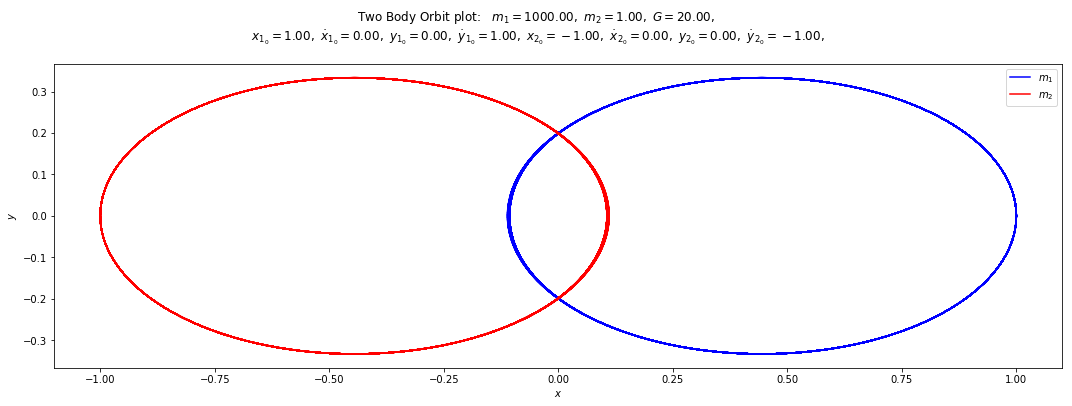

In [24]:
# Initial conditions for the plot
x1_0 = 1.
x1_dot_0 = 0.
y1_0 = 0.
y1_dot_0 = 1.

x2_0 = -1.
x2_dot_0 = 0.
y2_0 = 0.
y2_dot_0 = -1.

x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode(t_pts, 
                                                x1_0, x1_dot_0,
                                                y1_0, y1_dot_0,
                                                x2_0, x2_dot_0,
                                                y2_0, y2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Two Body Orbit plot:  ' + \
                rf' $m_1 = {mass1:.2f},$' + \
                rf' $m_2 = {mass2:.2f},$' + \
                rf' $G = {G:.2f},$' + \
                '\n' + \
                rf' $x_{{1_0}} = {x1_0:.2f},$' + \
                rf' $\dot x_{{1_0}} = {x1_dot_0:.2f},$' + \
                rf' $y_{{1_0}} = {y1_0:.2f},$' + \
                rf' $\dot y_{{1_0}} = {y1_dot_0:.2f},$' + \
                rf' $x_{{2_0}} = {x2_0:.2f},$' + \
                rf' $\dot x_{{2_0}} = {x2_dot_0:.2f},$' + \
                rf' $y_{{2_0}} = {y2_0:.2f},$' + \
                rf' $\dot y_{{2_0}} = {y2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# Plot the angle of both pendulums on the same plot  
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, 50.)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label=r'$m_1$', 
            title=None, 
            ax=ax_a)                                                   
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label=r'$m_2$', 
            title=None, 
            ax=ax_a)    


fig.tight_layout()
fig.savefig('TwoBodyOrbit', bbox_inches='tight', dpi=200.)  # always bbox_inches='tight'

In [22]:
# Labels for individual plot axes
x_vs_y_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Orbit parameters
mass1 = 1000.
mass2 = 1.
G = 20.

# Instantiate a pendulum 
o2 = TwoBodyOrbit(mass1=mass1, mass2=mass2, G=G)

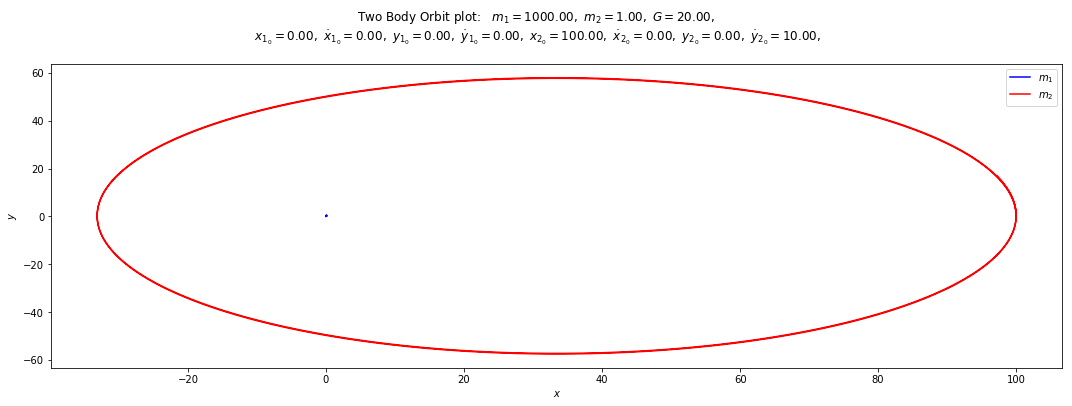

In [26]:
# Initial conditions for the plot
x1_0 = 0.
x1_dot_0 = 0.
y1_0 = 0.
y1_dot_0 = 0.

x2_0 = 100.
x2_dot_0 = 0.
y2_0 = 0.
y2_dot_0 = 10.

x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o2.solve_ode(t_pts, 
                                                x1_0, x1_dot_0,
                                                y1_0, y1_dot_0,
                                                x2_0, x2_dot_0,
                                                y2_0, y2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Two Body Orbit plot:  ' + \
                rf' $m_1 = {mass1:.2f},$' + \
                rf' $m_2 = {mass2:.2f},$' + \
                rf' $G = {G:.2f},$' + \
                '\n' + \
                rf' $x_{{1_0}} = {x1_0:.2f},$' + \
                rf' $\dot x_{{1_0}} = {x1_dot_0:.2f},$' + \
                rf' $y_{{1_0}} = {y1_0:.2f},$' + \
                rf' $\dot y_{{1_0}} = {y1_dot_0:.2f},$' + \
                rf' $x_{{2_0}} = {x2_0:.2f},$' + \
                rf' $\dot x_{{2_0}} = {x2_dot_0:.2f},$' + \
                rf' $y_{{2_0}} = {y2_0:.2f},$' + \
                rf' $\dot y_{{2_0}} = {y2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# Plot the angle of both pendulums on the same plot  
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, 50.)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label=r'$m_1$', 
            title=None, 
            ax=ax_a)                                                   
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label=r'$m_2$', 
            title=None, 
            ax=ax_a)    


fig.tight_layout()
fig.savefig('TwoBodyOrbit_Heavy', bbox_inches='tight', dpi=200.)  # always bbox_inches='tight'